# Analyzing RNA modification casued RNA-seq errors (CPU-based)

## Part I All records

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27

## 0.1 Configure the environment

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

tracemalloc.start()

## 0.2 Define functions

In [2]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [3]:
def cluster_HDBSCAN_softclustering(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [4]:
def subcluster_HDBSCAN_softclustering(df, target=None, cluster_col="Cluster", min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, alpha=1., cluster_selection_method='leaf', draw_condensed_tree=True):
    # use multi-code here
    df = df.copy()
    max_cluster_id = df[cluster_col].max()
    
    df1 = df[df[cluster_col]==target].copy()
    
    X = np.stack([df1["X"], df1["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=50, cluster_selection_method=cluster_selection_method, alpha=1., core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    # labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df1[cluster_col] = [max_cluster_id + i + 1 for i in labels ]  # re-number lables to make it human-readable
    df.loc[df1.index, cluster_col] = df1[cluster_col].tolist()
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    # print("==================================================")
    # check cluster number
    print(df.groupby(cluster_col)[cluster_col].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model

In [5]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0, label_size=12, draw_marker=True):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=label_size) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
    if draw_marker == True:
        df_marked = df[df["known_mod"].isnull()==False].copy()
        for idx, row in df_marked.iterrows():
            ax.scatter(row["X"], row["Y"], s=5, c="navy")
            ax.annotate(row["known_mod"], xy=(row["X"], row["Y"]), ha="left", va="bottom")
            print("Cluster #{}: {}".format(row["Cluster"], row["known_mod"]))

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax 

In [6]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [7]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

In [8]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

## 1. Load data from csv

We use the supplementary table from Tan et al. (doi:10.1126/sciadv.abd2605). Only sites with certian strandness were analyzed.

In [9]:
def load_sequences_from_csv(fn, sample_name):
    from Bio import SeqIO
    global dfs
    indexes = []
    if fn.endswith(".csv"):
        for idx, row in pd.read_csv(fn, index_col=None, header=0).iterrows():
            chr = row["chrom"]
            pos = row["position"]
            strand = row["Strand"]
            if strand == "plus":
                strand = "+"
            elif strand == "minus":
                strand = "-"
            else:
                if row["known modification"]:
                    strand = "un"
                else:
                    continue

            ID = "{}@{}@{}".format(chr, pos, strand)
            seq = str(row["motif_F10"]).upper()
            if seq is None or len(seq) != 21:  # skip non-T sequences
                continue
            all_sequences[ID] = seq
            all_bases[ID] = seq[10]
            num_of_sample[ID] = row["number_of_samples_detected"]
            indexes.append(ID)
            known_mod_base[ID] = row["known modification"]
            
    subdf = pd.DataFrame(index=indexes, columns=[sample_name])
    subdf = subdf[~subdf.index.duplicated(keep='first')]
    subdf[sample_name] = True
    dfs.append(subdf)

In [10]:
all_sequences = {}
all_bases = {}
num_of_sample = {}
known_mod_base = {}

dfs = []

load_sequences_from_csv("Tan_many_types.F10.marked.csv", "Tan et al")

df = dfs[0]
df["motif_F10"] = df.apply(lambda x: all_sequences.get(x.name), axis=1)
df["base"] = df.apply(lambda x: all_bases.get(x.name), axis=1)
df["num_of_sample"] = df.apply(lambda x: num_of_sample.get(x.name), axis=1)
df["known_mod"] = df.apply(lambda x: known_mod_base.get(x.name), axis=1)
#df = df[df["num_of_sample"]>=10]

df_A = df[df["base"]=="A"]
df_T = df[df["base"]=="T"]
df_C = df[df["base"]=="C"]
df_G = df[df["base"]=="G"]

## 1. A variants

In [11]:
onehot_input_A = []
for idx, row in df_A.iterrows():
    onehot_input_A.append(onehot_enc(row))
onehot_input_A = np.array(onehot_input_A)

In [12]:
_, _, df_A = UMAP(onehot_input_A, df_A, verbose=False)

UMAP
UMAP time: 20.087528705596924 sec
UMAP RAM: 101.44242191314697 MB



HDBSCAN soft clustering time: 0.38576245307922363 sec
HDBSCAN soft clustering RAM: 89.24137020111084 Mb
HDBSCAN cluster number: 19
Cluster
1      27
2      60
3     143
4      38
5      80
6      55
7     106
8      87
9     146
10     84
11    220
12    321
13    119
14    106
15    241
16    283
17    114
18     99
19    193
Name: Cluster, dtype: int64


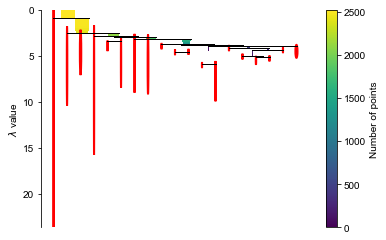

In [13]:
_, _, df_A, _= cluster_HDBSCAN_softclustering(df_A, min_cluster_size=20, min_samples=20, cluster_selection_method="leaf", cluster_selection_epsilon=0.0)

Cluster #1: m1A
Cluster #1: m1A
Cluster #1: m1A
Cluster #1: m1A
Cluster #1: m1A
Cluster #18: unknown
Cluster #18: unknown
Cluster #13: unknown
Cluster #19: unknown
Cluster #14: unknown


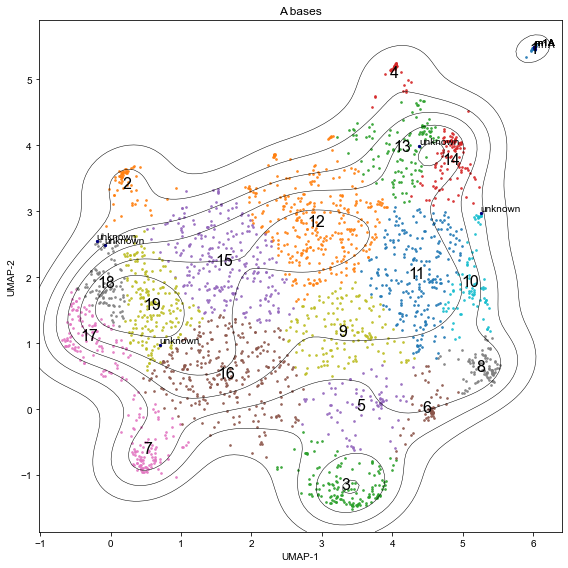

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_A, title="A bases", s=3, alpha=0.8, label_size=16)
plt.tight_layout()
plt.savefig("A_bases.png", dpi=300)

In [15]:
# Check what's inside
extract_fasta_and_draw_motifs("var_A", df_A)

===============  var_A ===============
Cluster #1: 27
Cluster #2: 60
Cluster #3: 143
Cluster #4: 38
Cluster #5: 80
Cluster #6: 55
Cluster #7: 106
Cluster #8: 87
Cluster #9: 146
Cluster #10: 84
Cluster #11: 220
Cluster #12: 321
Cluster #13: 119
Cluster #14: 106
Cluster #15: 241
Cluster #16: 283
Cluster #17: 114
Cluster #18: 99
Cluster #19: 193


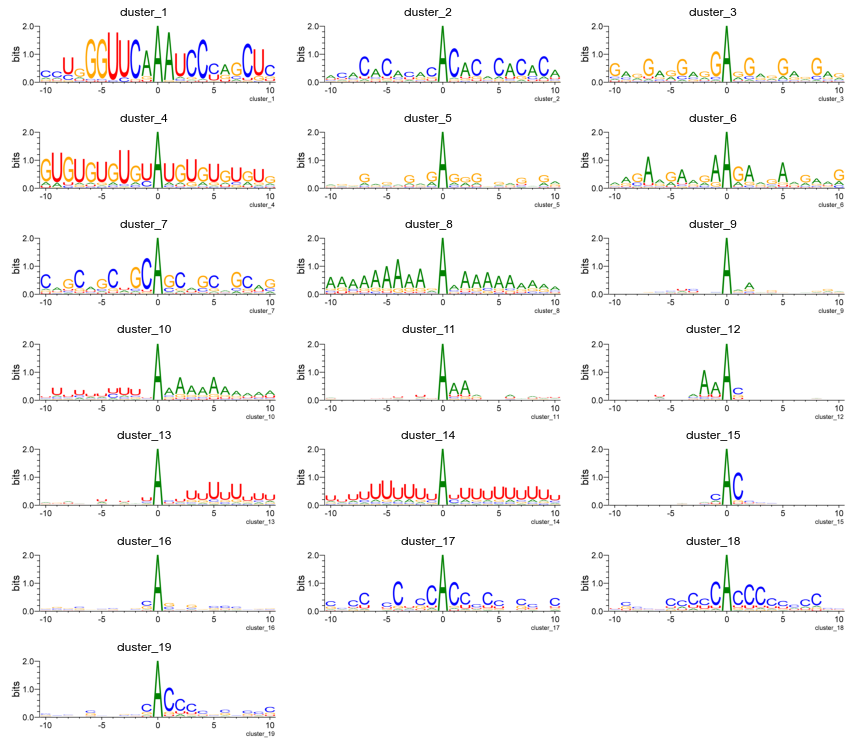

In [16]:
show_logos_cols("./var_A/logos_bits_png/", cols=3)

## 2. T variants

In [17]:
onehot_input_T = []
for idx, row in df_T.iterrows():
    onehot_input_T.append(onehot_enc(row))
onehot_input_T = np.array(onehot_input_T)

In [18]:
_, _, df_T = UMAP(onehot_input_T, df_T, verbose=False)

UMAP
UMAP time: 10.2652108669281 sec
UMAP RAM: 124.42293453216553 MB



HDBSCAN soft clustering time: 0.25032472610473633 sec
HDBSCAN soft clustering RAM: 118.68180751800537 Mb
HDBSCAN cluster number: 11
Cluster
1      42
2     203
3      90
4     111
5     115
6     200
7      57
8      96
9     221
10     68
11    709
Name: Cluster, dtype: int64


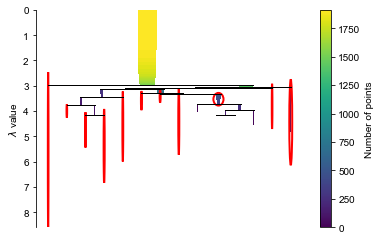

In [19]:
_, _, df_T, _= cluster_HDBSCAN_softclustering(df_T, min_cluster_size=20, min_samples=20, cluster_selection_epsilon=0.0)

Cluster #2: m1acp3Psi
Cluster #3: m3U


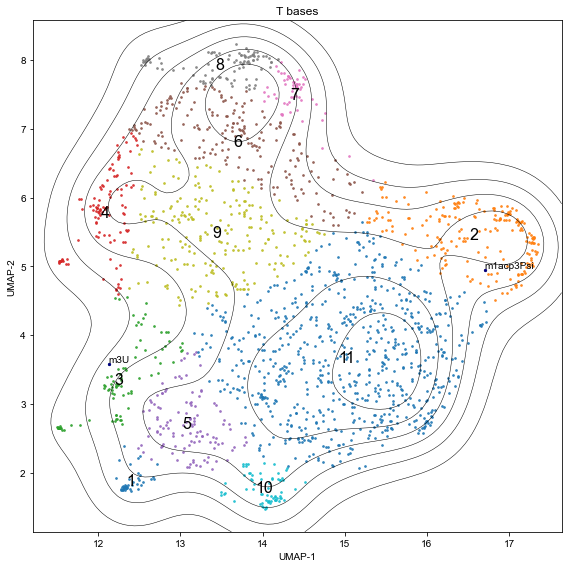

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_T, title="T bases", s=3, alpha=0.8, label_size=16)
plt.tight_layout()
plt.savefig("T_bases.png", dpi=300)

In [21]:
# Check what's inside
extract_fasta_and_draw_motifs("var_T", df_T)

===============  var_T ===============
Cluster #1: 42
Cluster #2: 203
Cluster #3: 90
Cluster #4: 111
Cluster #5: 115
Cluster #6: 200
Cluster #7: 57
Cluster #8: 96
Cluster #9: 221
Cluster #10: 68
Cluster #11: 709


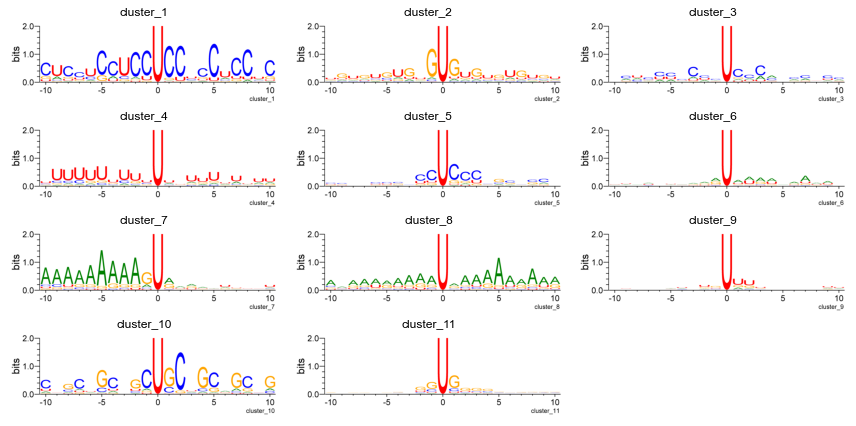

In [22]:
show_logos_cols("./var_T/logos_bits_png/", cols=3)

## 3. C variants

In [23]:
onehot_input_C = []
for idx, row in df_C.iterrows():
    onehot_input_C.append(onehot_enc(row))
onehot_input_C = np.array(onehot_input_C)

In [24]:
_, _, df_C = UMAP(onehot_input_C, df_C, verbose=False)

UMAP
UMAP time: 7.934232711791992 sec
UMAP RAM: 965.6548385620117 MB



HDBSCAN soft clustering time: 0.2065746784210205 sec
HDBSCAN soft clustering RAM: 959.7409286499023 Mb
HDBSCAN cluster number: 12
Cluster
1     151
2      44
3      62
4      59
5     150
6     100
7     194
8      85
9     103
10     63
11    104
12    449
Name: Cluster, dtype: int64


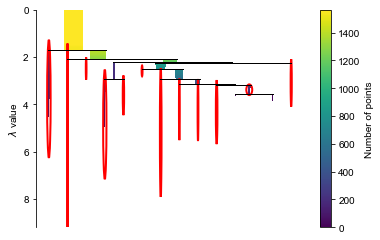

In [25]:
_, _, df_C, _= cluster_HDBSCAN_softclustering(df_C, min_cluster_size=20, min_samples=20, cluster_selection_epsilon=0.0)

Cluster #5: unknown
Cluster #7: m3C
Cluster #7: m3C
Cluster #12: m4C


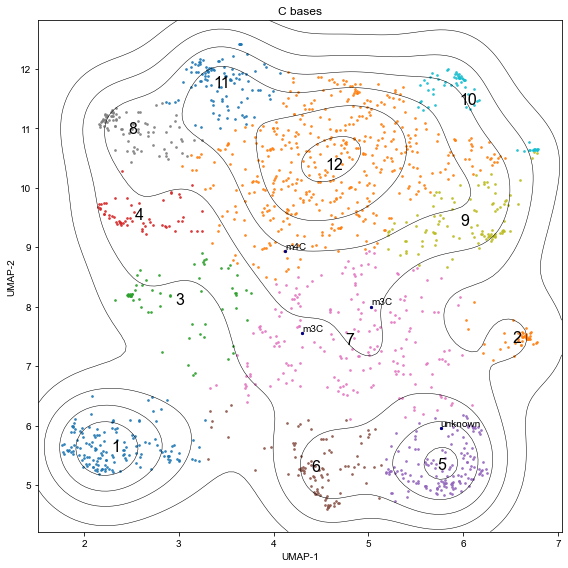

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_C, title="C bases", s=3, alpha=0.8, label_size=16)
plt.tight_layout()
plt.savefig("C_bases.png", dpi=300)

In [27]:
# Check what's inside
extract_fasta_and_draw_motifs("var_C", df_C)

===============  var_C ===============
Cluster #1: 151
Cluster #2: 44
Cluster #3: 62
Cluster #4: 59
Cluster #5: 150
Cluster #6: 100
Cluster #7: 194
Cluster #8: 85
Cluster #9: 103
Cluster #10: 63
Cluster #11: 104
Cluster #12: 449


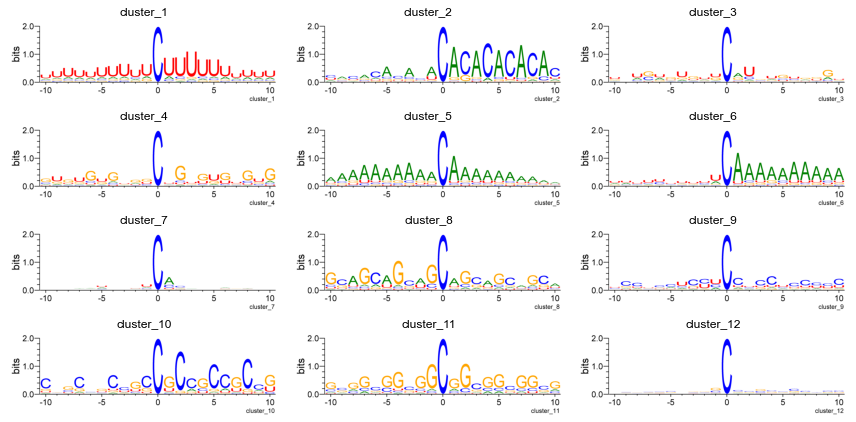

In [28]:
show_logos_cols("./var_C/logos_bits_png/", cols=3)

## 4. G variants

In [29]:
onehot_input_G = []
for idx, row in df_G.iterrows():
    onehot_input_G.append(onehot_enc(row))
onehot_input_G = np.array(onehot_input_G)

In [30]:
_, _, df_G = UMAP(onehot_input_G, df_G, verbose=False)

UMAP
UMAP time: 243.32135272026062 sec
UMAP RAM: 385.65843296051025 MB



HDBSCAN soft clustering time: 0.8557112216949463 sec
HDBSCAN soft clustering RAM: 1451.4203386306763 Mb
HDBSCAN cluster number: 3
Cluster
1    1336
2    5512
3     377
Name: Cluster, dtype: int64


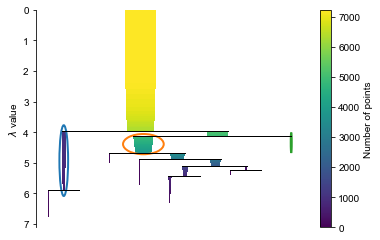

In [31]:
_, _, df_G, _= cluster_HDBSCAN_softclustering(df_G, min_cluster_size=100, min_samples=40, cluster_selection_method="eom", cluster_selection_epsilon=0.0)

Cluster #2: m22G
Cluster #2: m22G
Cluster #2: m22G


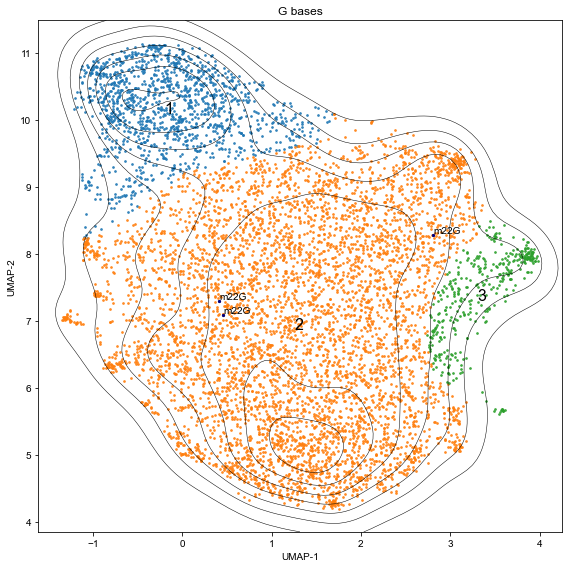

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_G, title="G bases", s=3, alpha=0.8, label_size=16)
plt.tight_layout()
plt.savefig("G_bases.png", dpi=300)

In [33]:
# Check what's inside
extract_fasta_and_draw_motifs("var_G", df_G)

===============  var_G ===============
Cluster #1: 1336
Cluster #2: 5512
Cluster #3: 377


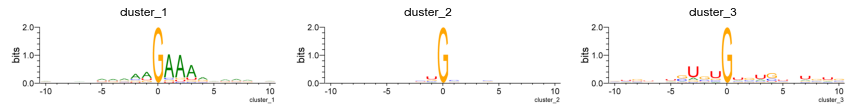

In [34]:
show_logos_cols("./var_G/logos_bits_png/", cols=3)

## Save tables to disk

In [35]:
df_A.to_csv("variant_A.csv")
df_T.to_csv("variant_T.csv")
df_C.to_csv("variant_C.csv")
df_G.to_csv("variant_G.csv")